In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../kddcup_corrected_subset/kddcup_corrected_subset.csv", index_col=None)

In [3]:
df.head()

,duration,"""protocol_type""","""flag""","""src_bytes""","""dst_bytes""","""land""","""wrong_fragment""","""urgent""",hot,"""num_failed_logins""",...,"""dst_host_srv_count""","""dst_host_same_srv_rate""","""dst_host_diff_srv_rate""","""dst_host_same_src_port_rate""","""dst_host_srv_diff_host_rate""",dst_host_serror_rate,"""dst_host_srv_serror_rate""","""dst_host_rerror_rate""","""dst_host_srv_rerror_rate""",label
0,0,tcp,SF,223,185,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,normal
1,0,tcp,SF,230,260,0,0,0,0,0,...,255,1,0,33,7,33,0,0,0,normal
2,0,tcp,SF,297,13787,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,normal
3,0,tcp,SF,291,3542,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,normal
4,0,tcp,SF,295,753,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,normal


In [4]:
df.shape

(41237, 41)

In [5]:
y = df["label"].values
from collections import Counter

Counter(y)

Counter({'normal': 39247,
         'apache2': 794,
         'phf': 2,
         'back': 1098,
         'neptune': 93,
         'portsweep': 2,
         'saint': 1})

In [6]:
from sklearn.preprocessing import LabelEncoder

encodings = dict()
for c in df.columns:
    if df[c].dtype == "object":
        encodings[c] = LabelEncoder()
        df[c] = encodings[c].fit_transform(df[c])

In [7]:
df.head()

,duration,"""protocol_type""","""flag""","""src_bytes""","""dst_bytes""","""land""","""wrong_fragment""","""urgent""",hot,"""num_failed_logins""",...,"""dst_host_srv_count""","""dst_host_same_srv_rate""","""dst_host_diff_srv_rate""","""dst_host_same_src_port_rate""","""dst_host_srv_diff_host_rate""",dst_host_serror_rate,"""dst_host_srv_serror_rate""","""dst_host_rerror_rate""","""dst_host_srv_rerror_rate""",label
0,0,0,7,223,185,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,3
1,0,0,7,230,260,0,0,0,0,0,...,255,1,0,33,7,33,0,0,0,3
2,0,0,7,297,13787,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,3
3,0,0,7,291,3542,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,3
4,0,0,7,295,753,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,3


In [8]:
y = df.pop("label").values
X = df.values

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

In [10]:
from sklearn.ensemble import IsolationForest

contamination_parameter = 1 - sum(
    y_train == encodings["label"].transform(["normal"])[0]
) / len(y_train)
IF = IsolationForest(
    n_estimators=100, max_samples=256, contamination=contamination_parameter
)

In [11]:
IF.fit(X_train)

IsolationForest(contamination=0.048987510609918794, max_samples=256)

In [12]:
scores = IF.decision_function(X_val)

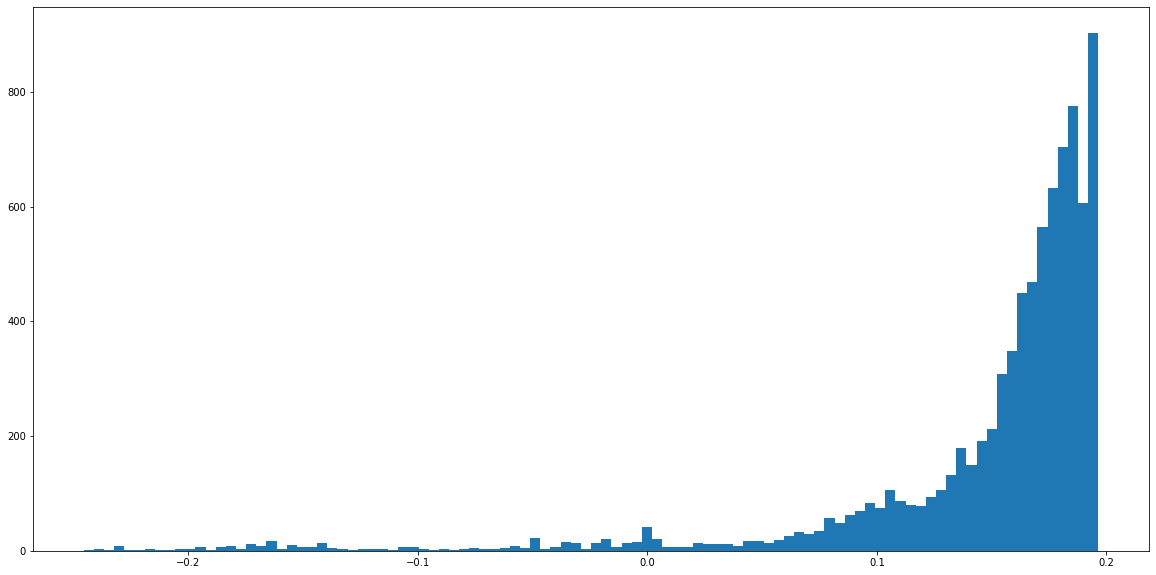

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 10))
_ = plt.hist(scores, bins=100)

In [14]:
cutoff = -0.07

In [15]:
print(Counter(y_val))
print(Counter(y_val[cutoff>scores]))

Counter({3: 7871, 1: 199, 0: 165, 2: 13})
Counter({0: 159, 1: 13, 2: 13, 3: 9})


In [16]:
scores_test = IF.decision_function(X_test)
print(Counter(y_test))
print(Counter(y_test[cutoff>scores_test]))

Counter({3: 7847, 1: 224, 0: 152, 2: 22, 6: 1, 5: 1, 4: 1})
Counter({0: 147, 2: 22, 1: 15, 3: 5, 6: 1, 5: 1})


In [20]:
y_val[y_val!=3]=0
y_val[y_val==3]=1

In [21]:
print(Counter(y_val))

Counter({1: 7871, 0: 377})


In [22]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_val, scores)
roc_auc = metrics.auc(fpr, tpr)

In [51]:
scores

array([0.1776531 , 0.18488277, 0.16715601, ..., 0.19556927, 0.16897642,
       0.16510301])

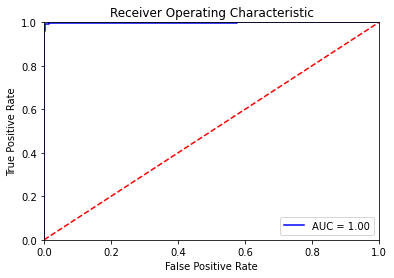

In [23]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
fpr

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [45]:
fpr[613]

0.002652519893899204

In [46]:
tpr

array([0.00000000e+00, 5.08194639e-04, 1.27048660e-03, 3.43031381e-03,
       3.81145979e-03, 4.06555711e-03, 4.31965443e-03, 4.82784907e-03,
       6.22538432e-03, 6.47948164e-03, 6.60653030e-03, 7.24177360e-03,
       7.36882226e-03, 8.13111422e-03, 8.38521154e-03, 8.51226020e-03,
       9.02045483e-03, 9.90979545e-03, 1.13073307e-02, 1.15614280e-02,
       1.24507686e-02, 1.32130606e-02, 1.34671579e-02, 1.74056664e-02,
       1.76597637e-02, 1.77868123e-02, 1.81679583e-02, 1.84220556e-02,
       1.86761530e-02, 1.95654936e-02, 1.98195909e-02, 2.13441748e-02,
       2.18523695e-02, 2.26146614e-02, 2.27417101e-02, 2.37580994e-02,
       2.40121967e-02, 2.45203913e-02, 2.49015373e-02, 2.52826833e-02,
       2.55367806e-02, 2.61720239e-02, 2.64261212e-02, 2.66802185e-02,
       2.69343158e-02, 2.87129971e-02, 2.90941431e-02, 2.92211917e-02,
       2.94752890e-02, 2.96023377e-02, 3.01105323e-02, 3.02375810e-02,
       3.17621649e-02, 3.20162622e-02, 3.25244569e-02, 3.36678948e-02,
      

In [47]:
tpr[613]

0.9941557616567145

In [52]:
thresholds

array([ 1.19650320e+00,  1.96503198e-01,  1.96451009e-01,  1.96345204e-01,
        1.96244493e-01,  1.96226348e-01,  1.96174114e-01,  1.96068217e-01,
        1.96034600e-01,  1.95982086e-01,  1.95919862e-01,  1.95895023e-01,
        1.95881030e-01,  1.95862559e-01,  1.95842735e-01,  1.95815000e-01,
        1.95813880e-01,  1.95745207e-01,  1.95736728e-01,  1.95722729e-01,
        1.95708984e-01,  1.95692895e-01,  1.95616578e-01,  1.95586839e-01,
        1.95583368e-01,  1.95569265e-01,  1.95564244e-01,  1.95531030e-01,
        1.95516316e-01,  1.95458146e-01,  1.95425286e-01,  1.95424920e-01,
        1.95330436e-01,  1.95289794e-01,  1.95266760e-01,  1.95253167e-01,
        1.95239906e-01,  1.95239147e-01,  1.95204396e-01,  1.95189798e-01,
        1.95160491e-01,  1.95137395e-01,  1.95131945e-01,  1.95116651e-01,
        1.95113175e-01,  1.95103053e-01,  1.95098686e-01,  1.95084046e-01,
        1.95063078e-01,  1.95061159e-01,  1.95054259e-01,  1.95053842e-01,
        1.95031156e-01,  

In [48]:
thresholds[613]

0.01465548413540696

In [49]:
chosen_threshold = 0.01465548413540696

In [50]:
scores_test = IF.decision_function(X_test)
print(Counter(y_test))
print(Counter(y_test[chosen_threshold>scores_test]))

Counter({3: 7847, 1: 224, 0: 152, 2: 22, 6: 1, 5: 1, 4: 1})
Counter({1: 219, 0: 151, 3: 45, 2: 22, 6: 1, 5: 1, 4: 1})
